# Nonstationary Multi-Armed Bandits

The code below generates  chapter 2 of "Reinforcement Learning: An Introduction" by Andrew Barto and Richard S. Sutton. The main issue is the Nonstationary Multi-Armed Bandits problem, whcih is addressed through epsilon-greedy, UCB and and gradient bandit algorithms: in order to do so, the 10 armed testbed is introduced.
In the 10-armed testbed environment for the Nonstationary Multi-Armed Bandits, the mean values $q(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:
$$ q_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$q_t(a) = q_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Assume $\sigma = 0.1$.

We will compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

In [2]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
        
        
    def reset(self):
        # real reward for each action
        self.q_true = np.zeros(self.k) + self.true_reward                  
        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial # [0, 0, 0]
        # # of chosen times for each action
        self.action_count = np.zeros(self.k)  #0
        #self.best_action = np.argmax(self.q_true)   #0.8
        self.time = 0
        
        
    # get an action for this bandit
    def act(self): # action = bandit.act()
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation) 
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    


    # take an action, update estimation for this action
    def step(self, action): #bandit.step(action)
        # generate the reward under N(real reward, 1)
        self.best_action = np.argmax(self.q_true)   
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
    
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action]) 
        return reward


In [3]:
def simulate(runs, time, bandits):
    m = 0
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward 
                
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1                    
                bandit.q_true += np.random.normal(0, 0.1, 10) 
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [4]:
runs = 500
time = 5000
eps = 0.1
sample_average = [True,False]
bandits = [Bandit(epsilon= eps, sample_averages=sample_avg, ) for sample_avg in  sample_average]
best_action_counts, rewards = simulate(runs,time,bandits)

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


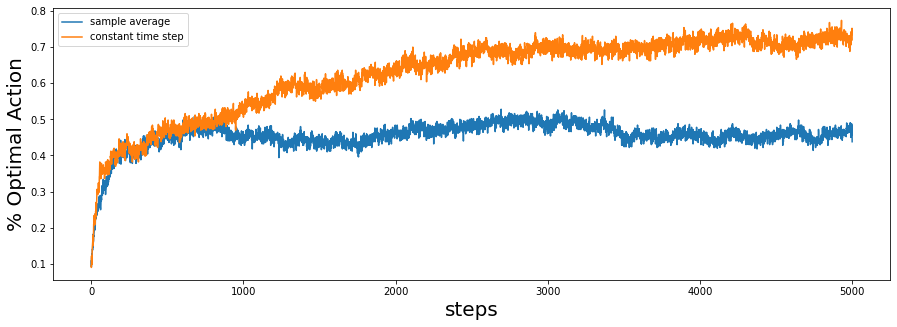

In [5]:
plt.figure(figsize=(15, 5))

plt.plot(best_action_counts[0])
plt.plot(best_action_counts[1])
plt.xlabel('steps',size = 20)
plt.ylabel('% Optimal Action',size = 20)
plt.legend(['sample average','constant time step'],loc = 2 ,prop={'size': 10})

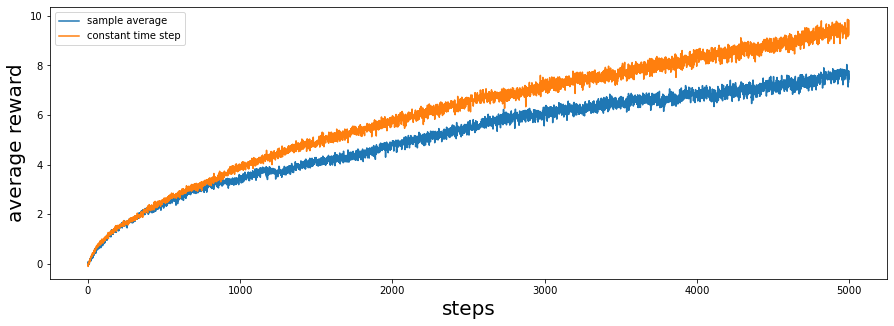

In [6]:
plt.figure(figsize=(15, 5))

plt.plot(rewards[0])
plt.plot(rewards[1])
plt.xlabel('steps',size = 20)
plt.ylabel('average reward',size = 20)
plt.legend(['sample average','constant time step'],loc = 2 ,prop={'size': 10})

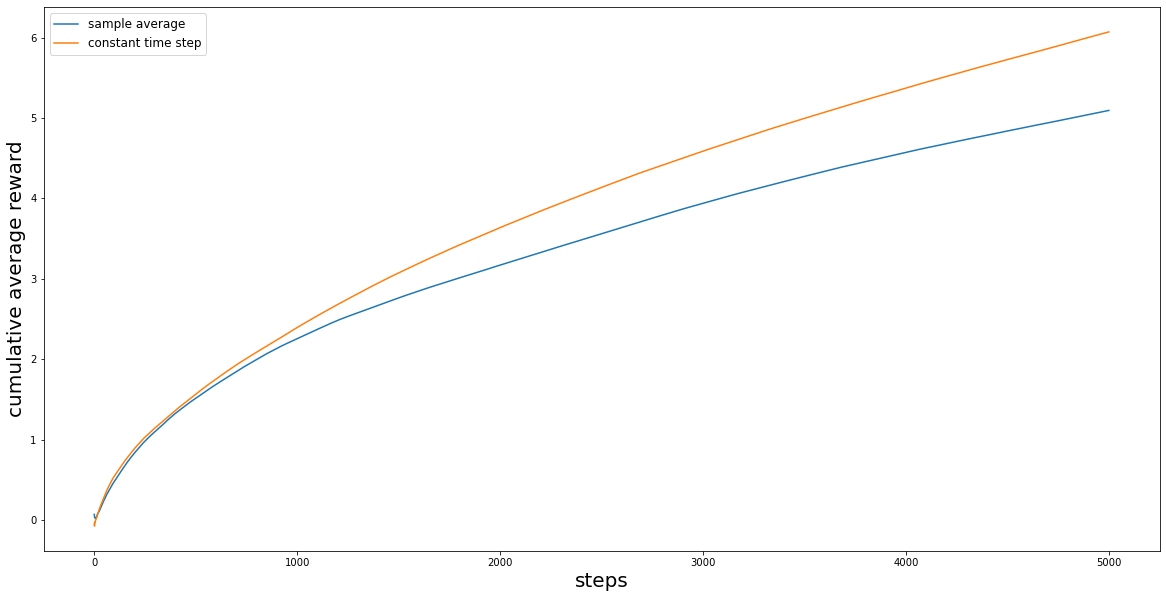

In [7]:
plt.figure(figsize=(20, 10))

data1 = np.cumsum(rewards[0,:])/(np.arange(rewards.shape[1])+1)
data2 = np.cumsum(rewards[1,:])/(np.arange(rewards.shape[1])+1)
plt.plot(data1)
plt.plot(data2)
plt.xlabel('steps',size = 20)
plt.ylabel('cumulative average reward',size = 20)
plt.legend(['sample average','constant time step'],loc = 2 ,prop={'size': 12})

As it is obvious, constant time steps for 𝜖−𝑔𝑟𝑒𝑒𝑑𝑦 perfroms a better behaviour in all plots. Because in sample average approach, the time steps changes as the time goes on. So the effect of penalty term in the equation which multiplyes the error, will decrease. This results in decreasing in the rate of reaching to the optimal. 

The first graph (%optimal action), As we expect, in the first steps, both approaches behave similiar. After step 200, constant time stpes approach, overtaken the sample average approach and the number of optimal actions is a lot more. 

The second graph (average rewards) shows the increase in the expected rewards with experience. At the begining, $\epsilon-greedy$ both methods, have a similar average rewards. However, very soon, constant time steps approach, overtakes the sample averages approach and finally reaches to an average raward near to 10. For the sample averages method, the final average reward is approximately 8.

As for the third graph, we are always trying to maximize the reward and cumulative reward is a good criteria to evaluate our job. Similiarly, As it is obvious, cumulative reward for constant time steps method, increase faster than the sample averages method.

With respect to our purpose which was the maximizing the reward with a faster rate, $\epsilon-greedy$ method with constant time steps has a better performance than $\epsilon-greedy$ with sample averages. 